In [ ]:
!pip install transformers

In [1]:
SEQ_LEN = 64
BATCH_SIZE = 256

In [7]:
import pandas as pd

df = pd.read_csv('cleaned-text-version-5.csv') 
df = df[['text', 'label']]
pd.set_option('display.max_colwidth', None)

In [8]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.25, random_state=50, shuffle=True)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=50, shuffle=True)

In [ ]:
from transformers import AutoConfig, AutoTokenizer

parsBert_base_model_path = 'HooshvareLab/bert-fa-zwnj-base' 
config = AutoConfig.from_pretrained(parsBert_base_model_path)
tokenizer = AutoTokenizer.from_pretrained(parsBert_base_model_path)

In [19]:
tokens = tokenizer(train_data['text'].tolist(), max_length=SEQ_LEN,
                  truncation=True, padding='max_length',
                  add_special_tokens=True,
                  return_tensors='tf')

In [20]:
val_data_tokens = tokenizer(val_data['text'].tolist(), max_length=SEQ_LEN,
                  truncation=True, padding='max_length',
                  add_special_tokens=True,
                  return_tensors='tf')

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform([(x,) for x in train_data['label']])
val_labels = mlb.fit_transform([(x,) for x in val_data['label']])

In [22]:
import tensorflow as tf

def map_func(input_ids, attention_mask, labels):
    return ({'input_ids': input_ids,
            'attention_mask': attention_mask}, labels)

# train_size = int((tokens['input_ids'].shape[0] / BATCH_SIZE) * 0.8)

train_dataset = tf.data.Dataset.from_tensor_slices((tokens['input_ids'], tokens['attention_mask'], labels))
train_dataset = train_dataset.map(map_func)
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)


val_dataset = tf.data.Dataset.from_tensor_slices((val_data_tokens['input_ids'], val_data_tokens['attention_mask'], val_labels))
val_dataset = val_dataset.map(map_func)
val_dataset = val_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
from transformers import TFAutoModel, TFBertForSequenceClassification
parsBert = TFAutoModel.from_pretrained(parsBert_base_model_path)

parsBert_sentiment_model_path = 'HooshvareLab/bert-fa-base-uncased-sentiment-deepsentipers-multi'
sementicModel = TFBertForSequenceClassification.from_pretrained(parsBert_sentiment_model_path)

In [24]:
import tensorflow as tf
import Attention_Class as Attention

input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = parsBert.bert(input_ids, attention_mask=mask)  

CNN=tf.keras.layers.Conv1D(128, 3, activation='relu')(embeddings[0])
Max_Pool=tf.keras.layers.MaxPooling1D(pool_size=2)(CNN)

LSTM= tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(Max_Pool)
LSTM_Drop = tf.keras.layers.Dropout(0.3)(LSTM)
# LSTM_Drop_concat = tf.keras.layers.concatenate([LSTM_Drop, Max_Pool])
atten_lstm= Attention.attention()(LSTM_Drop)
# atten_lstm= tf.keras.layers.Attention()(input_ids,mask)

GRU1= tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True, go_backwards=True))(Max_Pool)
GRU1_Drop = tf.keras.layers.Dropout(0.3)(GRU1)
# GRU1_Drop_concat = tf.keras.layers.concatenate([GRU1_Drop, Max_Pool])
atten_gru= Attention.attention()(GRU1_Drop)
# atten_gru = tf.keras.layers.Attention()(input_ids,mask)

# flatten_embeddings = tf.keras.layers.Flatten()(embeddings[0]), flatten_embeddings
atten_merged = tf.keras.layers.concatenate([atten_lstm, atten_gru])
flatten_parsbase = tf.keras.layers.Flatten()(atten_merged)

x = tf.keras.layers.Dense(32, activation='relu')(flatten_parsbase)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(16, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)

semanticAnswer = sementicModel([input_ids, mask]).logits
flatten_sent = tf.keras.layers.Flatten()(semanticAnswer)

x = tf.keras.layers.concatenate([flatten_sent, x])
x = tf.keras.layers.Dense(8, activation='relu')(x)#, kernel_regularizer=tf.keras.regularizers.l1()

Final_output = tf.keras.layers.Dense(2, activation ='linear', trainable=True)(x)

In [25]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=Final_output)
for l in model.layers:
  if 'bert' in l.name:
    l.trainable = False

In [ ]:
for l in model.layers:
    print(l.name, l.trainable)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  118297344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                            

In [28]:
optimizer = tf.keras.optimizers.Adam() #learning_rate=1e-4, decay=1e-6
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [29]:
checkpoint_filepath = 'checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = tf.keras.callbacks.History()

In [31]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=history)

Epoch 1/10
8/8 [==============================] - 21s 3s/step - loss: 0.4784 - accuracy: 0.7822 - val_loss: 0.5529 - val_accuracy: 0.7617
Epoch 2/10
8/8 [==============================] - 21s 3s/step - loss: 0.4509 - accuracy: 0.7900 - val_loss: 0.5805 - val_accuracy: 0.7656
Epoch 3/10
8/8 [==============================] - 21s 3s/step - loss: 0.4374 - accuracy: 0.7910 - val_loss: 0.6283 - val_accuracy: 0.6875
Epoch 4/10
8/8 [==============================] - 20s 3s/step - loss: 0.4231 - accuracy: 0.8037 - val_loss: 0.6084 - val_accuracy: 0.7383
Epoch 5/10
8/8 [==============================] - 22s 3s/step - loss: 0.3825 - accuracy: 0.8315 - val_loss: 0.6905 - val_accuracy: 0.7266
Epoch 6/10
8/8 [==============================] - 21s 3s/step - loss: 0.3631 - accuracy: 0.8384 - val_loss: 0.6847 - val_accuracy: 0.7305
Epoch 7/10
8/8 [==============================] - 22s 3s/step - loss: 0.3383 - accuracy: 0.8574 - val_loss: 0.6841 - val_accuracy: 0.7500
Epoch 8/10
8/8 [==================

Text(0.5, 0, 'Epochs')

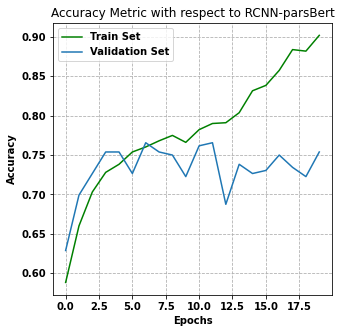

In [32]:
import matplotlib.pyplot as plt

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize = (5,5))
plt.grid(linestyle = 'dashed')
plt.plot(history.history['accuracy'][:], c = 'green')
plt.plot(history.history['val_accuracy'][:])
plt.title('Accuracy Metric with respect to RCNN-parsBert')
plt.legend(['Train Set', 'Validation Set'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

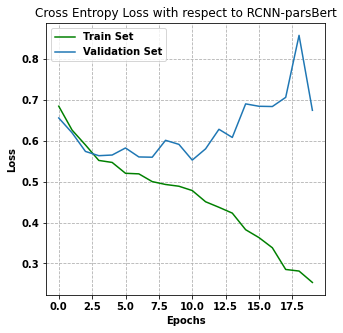

In [33]:
# "Loss"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize = (5,5))
plt.grid(linestyle = 'dashed')
plt.plot(history.history['loss'][:], c = 'green')
plt.plot(history.history['val_loss'][:])
plt.title('Cross Entropy Loss with respect to RCNN-parsBert')
plt.legend(['Train Set', 'Validation Set'])
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [ ]:
model.load_weights('checkpoint/checkpoint')

In [34]:
def prep_data(text):
    tokens = tokenizer(text, max_length=SEQ_LEN, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
    return ({'input_ids': tokens['input_ids'], 'attention_mask': tokens['attention_mask']})

In [ ]:
import numpy as np

test_data['predicted-label'] = None

for i, text in zip(test_data['number'], test_data['text']):
    tokens = prep_data(text)
    probs = model.predict(tokens)
    pred = np.argmax(probs)
    test_data['predicted-label'][i] = pred

In [ ]:
test_true_positive = 0
test_true_negetive = 0
test_false_positive = 0
test_false_negetive = 0

for p,g in zip(test_data['predicted-label'],test_data['label']):
    test_true_negetive += 1 if (p == 0 and g == 0) else 0
    test_true_positive += 1 if (p == 1 and g == 1) else 0
    test_false_negetive += 1 if (p == 0 and g == 1) else 0
    test_false_positive += 1 if (p == 1 and g == 0) else 0


test_recall = test_true_positive/ (test_true_positive+test_false_negetive)
test_percision = test_true_positive/ (test_true_positive+test_false_positive)
test_f1 = (2*test_percision*test_recall) / (test_percision+test_recall)
test_accuracy = (test_true_positive + test_true_negetive) / len(test_data)

print('TEST:')
print('recall : {}'.format(test_recall))
print('percision : {}'.format(test_percision))
print('f1-score : {}'.format(test_f1))
print('accuracy : {}'.format(test_accuracy))


TEST:
recall : 0.5576923076923077
percision : 0.7131147540983607
f1-score : 0.6258992805755396
accuracy : 0.717391304347826


In [ ]:
val_data['predicted-label'] = None

for i, text in zip(val_data['number'], val_data['text']):
    tokens = prep_data(text)
    probs = model.predict(tokens)
    pred = np.argmax(probs)
    val_data['predicted-label'][i] = pred

In [ ]:
val_true_positive = 0
val_true_negetive = 0
val_false_positive = 0
val_false_negetive = 0

for p,g in zip(val_data['label'],val_data['predicted-label']):
    val_true_negetive += 1 if (p == 0 and g == 0) else 0
    val_true_positive += 1 if (p == 1 and g == 1) else 0
    val_false_negetive += 1 if (p == 0 and g == 1) else 0
    val_false_positive += 1 if (p == 1 and g == 0) else 0


val_recall = val_true_positive/ (val_true_positive+val_false_negetive)
val_percision = val_true_positive/ (val_true_positive+val_false_positive)
val_f1 = (2*val_percision*val_recall) / (val_percision+val_recall)
val_accuracy = (val_true_positive + val_true_negetive) / len(val_data)

print('VALIDATION:')
print('recall : {}'.format(val_recall))
print('percision : {}'.format(val_percision))
print('f1-score : {}'.format(val_f1))
print('accuracy : {}'.format(val_accuracy))

VALIDATION:
recall : 0.8317757009345794
percision : 0.536144578313253
f1-score : 0.652014652014652
accuracy : 0.7418478260869565


In [ ]:
train_data['predicted-label'] = None

for i, text in zip(train_data['number'], train_data['text']):
    tokens = prep_data(text)
    probs = model.predict(tokens)
    pred = np.argmax(probs)
    train_data['predicted-label'][i] = pred

In [ ]:
train_true_positive = 0
train_true_negetive = 0
train_false_positive = 0
train_false_negetive = 0

for p,g in zip(train_data['label'],train_data['predicted-label']):
    train_true_negetive += 1 if (p == 0 and g == 0) else 0
    train_true_positive += 1 if (p == 1 and g == 1) else 0
    train_false_negetive += 1 if (p == 0 and g == 1) else 0
    train_false_positive += 1 if (p == 1 and g == 0) else 0


train_recall = train_true_positive/ (train_true_positive+train_false_negetive)
train_percision = train_true_positive/ (train_true_positive+train_false_positive)
train_f1 = (2*train_percision*train_recall) / (train_percision+train_recall)
train_accuracy = (train_true_positive + train_true_negetive) / len(train_data)

print('TRAIN:')
print('recall : {}'.format(train_recall))
print('percision : {}'.format(train_percision))
print('f1-score : {}'.format(train_f1))
print('accuracy : {}'.format(train_accuracy))

TRAIN:
recall : 1.0
percision : 1.0
f1-score : 1.0
accuracy : 1.0


In [ ]:
all_true_positive = train_true_positive + test_true_positive
all_true_negetive = train_true_negetive + test_true_negetive
all_false_positive = train_false_positive + test_false_positive
all_false_negetive = train_false_negetive + test_false_negetive
all_count = len(test_data) + len (train_data)

all_recall = all_true_positive/ (all_true_positive+all_false_negetive)
all_percision = all_true_positive/ (all_true_positive+all_false_positive)
all_f1 = (2*all_percision*all_recall) / (all_percision+all_recall)
all_accuracy = (all_true_positive + all_true_negetive) / all_count

print('ALL:')
print('recall : {}'.format(all_recall))
print('percision : {}'.format(all_percision))
print('f1-score : {}'.format(all_f1))
print('accuracy : {}'.format(all_accuracy))



ALL:
recall : 0.9812206572769953
percision : 0.9819890368050117
f1-score : 0.9816046966731897
accuracy : 0.9840190411424685
